<a href="https://colab.research.google.com/github/Harooniqbal4879/AgenticAI/blob/main/Build_Your_Adv_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to LangGraph**



Welcome! In this warm-up you’ll the key concepts of **LangGraph**.  

By the end you can:

| You will be able to… | Why it matters |
| --- | --- |
| Explain the parts of a `StateGraph` | All LangGraph projects share these building blocks |
| Write & connect multiple agents | Real-world apps chain specialised LLM tools |
| Inspect state as it flows | Debugging & observability are key |

---

### 📖 Table of Contents  
1. [Install dependencies](#install)  
2. [Define shared state](#state)  
3. [Create three agents](#agents)  
4. [Build the graph](#graph)  
5. [Run & inspect](#run)  
6. [Next steps](#next)


<a id="install"></a>
## Step 1  — Install Dependencies

We need **LangGraph** for orchestration and **LangChain** for helper classes.  
Run the cell below, then **restart the kernel** so the new packages load cleanly.


In [ ]:
!pip install -q --upgrade langgraph langchain  # ! not bare ‘pip’ for Jupyter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 670.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 6.8 MB/s eta 0:00:00


## Step 2  — Define the Shared State

The **state** is a single `TypedDict` that every agent can **read** and **update**  
— think of it as a strongly-typed, mutable “whiteboard”.

In [ ]:
from typing import TypedDict

class TravelState(TypedDict, total=False):
    user_input: str          # raw question
    destination: str         # “Bali”, “Manali”, …
    itinerary: str           # multi-day plan
    activities: str          # granular activities

## Step 3  — Create Three Simple Agents

| Agent | Responsibility |
| --- | --- |
| `destination_agent` | Choose a place that matches the user’s intent |
| `itinerary_agent` | Draft a rough, three-day itinerary |
| `activity_agent` | Suggest activities fitting that place |

Each agent is an ordinary Python function that takes `TravelState` ➜ returns an **updated** `TravelState`.


In [ ]:
def destination_agent(state: TravelState) -> TravelState:
    print("🔧 destination_agent running…")
    q = state.get("user_input", "").lower()

    if "beach" in q:
        dest = "Bali"
    elif "snow" in q or "mountain" in q:
        dest = "Manali"
    else:
        dest = "Kyoto"  # sensible default

    print(f"🌍 Suggested destination: {dest}")
    return {**state, "destination": dest}

In [ ]:
def itinerary_agent(state: TravelState) -> TravelState:
    print("🔧 itinerary_agent running…")
    dest = state["destination"]
    plan = (
        f"Day 1: Arrive in {dest}\n"
        f"Day 2: Explore iconic spots in {dest}\n"
        f"Day 3: Relax + sample local cuisine"
    )
    print(f"🧳 Draft itinerary:\n{plan}")
    return {**state, "itinerary": plan}

In [ ]:
def activity_agent(state: TravelState) -> TravelState:
    print("🔧 activity_agent running…")
    dest = state["destination"]
    act = (
        "Snorkelling • Beach yoga"
        if dest == "Bali"
        else "Skiing • Mountain trek"
    )
    print(f"🎯 Suggested activities: {act}")
    return {**state, "activities": act}

## Step 4  — Build the LangGraph Workflow

A `StateGraph` wires **nodes** (our agents) with **edges** (execution order).  
Below we:

1. add each agent as a node  
2. set the entry & finish points  
3. connect the nodes in series  
4. compile to an executable graph


In [ ]:
from langgraph.graph import StateGraph

builder = StateGraph(TravelState)

builder.add_node("destination_agent", destination_agent)
builder.add_node("itinerary_agent", itinerary_agent)
builder.add_node("activity_agent", activity_agent)

builder.set_entry_point("destination_agent")
builder.add_edge("destination_agent", "itinerary_agent")
builder.add_edge("itinerary_agent", "activity_agent")
builder.set_finish_point("activity_agent")

travel_graph = builder.compile()
print("✅ Graph compiled.")

✅ Graph compiled.


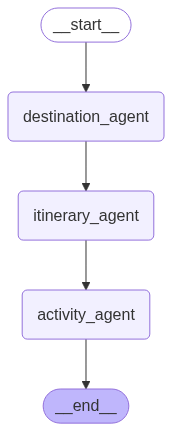

In [ ]:
from IPython.display import Image, display

display(Image(travel_graph.get_graph().draw_mermaid_png()))

## Step 5  — Run & Inspect

Let’s invoke the graph with a sample query and watch the logged output.

In [ ]:
initial_state: TravelState = {
    "user_input": "I want a relaxing beach vacation"
}

final_state = travel_graph.invoke(initial_state)

print("\n🏁 Final state:")
for k, v in final_state.items():
    print(f"{k}: {v}")

🔧 destination_agent running…
🌍 Suggested destination: Bali
🔧 itinerary_agent running…
🧳 Draft itinerary:
Day 1: Arrive in Bali
Day 2: Explore iconic spots in Bali
Day 3: Relax + sample local cuisine
🔧 activity_agent running…
🎯 Suggested activities: Snorkelling • Beach yoga

🏁 Final state:
user_input: I want a relaxing beach vacation
destination: Bali
itinerary: Day 1: Arrive in Bali
Day 2: Explore iconic spots in Bali
Day 3: Relax + sample local cuisine
activities: Snorkelling • Beach yoga


## 🔬 Understanding State Transitions

Below is a condensed view of how the state mutated:

| After node | `destination` | `itinerary` | `activities` |
| --- | --- | --- | --- |
| **initial** | — | — | — |
| `destination_agent` | ✅ | — | — |
| `itinerary_agent` | ✅ | ✅ | — |
| `activity_agent` | ✅ | ✅ | ✅ |

Each agent **adds** to (or updates) the same `TravelState` object — no hidden globals.


## ✏️ Your Turn  — Get Your Hands Dirty

1. **Snow scenario** — Change the input to “I want a snowy mountain retreat” and re-run.  
   *What destination, itinerary, and activities do you get?*

2. **Branching logic** — Extend `destination_agent` to detect “city break” and route to **Paris**, then tweak `itinerary_agent` accordingly.

*(Feel free to add extra cells beneath this one.)*


# **Build a Multi-Agent System**





## Our Learning Path


| Step | Focus Area             | Description                                     |
|------|------------------------|-------------------------------------------------|
| 1️⃣   | Simple Agent           | Start by creating a basic LLM-powered agent     |
| 2️⃣   |  Multi-Agent System   |  Combine multiple agents using LangGraph    |
| 3️⃣   |  + Short-Term Memory   | Enhance the agent with session-level memory       |





## Step 1 — Setup & Imports


Before we dive into building agents, let's set up our development environment. We'll be using:

- **Google Gemini**: Our powerful LLM for natural language understanding
- **LangGraph**: Framework for building stateful, multi-agent workflows
- **LangChain**: Tools for LLM application development

### Why These Tools?

- **Gemini**: Fast, cost-effective, and excellent for conversational AI
- **LangGraph**: Perfect for complex workflows with multiple agents
- **Environment Variables**: Secure way to handle API keys


In [ ]:
# Install packages (run in terminal or uncomment)
!pip install -q google-generativeai==0.8.5 google-ai-generativelanguage==0.6.15
!pip install -q langchain-google-genai langgraph python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-genai 2.1.5 requires google-ai-generativelanguage<0.7.0,>=0.6.18, but you have google-ai-generativelanguage 0.6.15 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
!pip install -q langchain

#### **Set Up API Key for Google AI Studio**

Follow these steps to create and configure your API key for using Google’s AI services (like Gemini):

---

##### 1. Visit the API Key Page

Open the following link in your browser:

👉 [https://aistudio.google.com/apikey](https://aistudio.google.com/apikey)

---

##### 2. Create an API Key

- Sign in with your Google account (if prompted).
- Click on **"Create API Key"**.
- Your API key will be generated — **copy it and keep it secure**.

---

##### 3. Paste Your API Key in the Cell Below

In [ ]:
from dotenv import load_dotenv
import os, getpass

# Load API key
load_dotenv()
os.environ["GOOGLE_API_KEY"] = getpass.getpass("GOOGLE_API_KEY")

GOOGLE_API_KEY··········


In [ ]:
# Import everything we need
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

## Step 2 — Core LLM Chain

We’ll now set up the core LLM using the `ChatGoogleGenerativeAI` class from LangChain (or your preferred wrapper). This model will power our generative AI tasks.




In [ ]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.2
)

## Step 3 - Create Individual Agents

### Itenary Agent

Helps in planning the full travel itinerary and provides travel-related answers

In [ ]:
# Install required libraries for Tavily
!pip install -q tavily-python langchain-community

In [ ]:
# Import necessary modules
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from typing import TypedDict, Annotated, List, Union
import json

###### Set Up Tavily API Key

Tavily provides real-time web search capabilities for LLMs. To use it, you'll need an API key.

---

##### Get Your Tavily API Key

1. Visit the Tavily dashboard:  
   👉 [https://app.tavily.com/home](https://app.tavily.com/home)
2. Sign in or create an account.
3. Go to the **API Keys** section.
4. Copy your API key.

---

##### Enter Your API Key Securely in Colab

In [ ]:
# Step 1: Set up Tavily client and API key
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")
#tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

TAVILY_API_KEY··········


In [ ]:
# Install or upgrade the LangChain-Tavily integration package silently
!pip install -q -U langchain-tavily

###### Use TavilySearch Tool from LangChain

Now that we’ve set up the Tavily API key, we can use the `TavilySearch` tool to perform real-time web searches within LangChain.

In [ ]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]

In [ ]:
# Test TavilySearch
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'content': 'Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph. We define nodes for classifying the input, handling greetings, and handling search queries. def classify_input_node(state): LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its powe

In [ ]:
# itinerary agent prompt to include ReAct reasoning
itenary_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an expert travel itinerary planner. ONLY respond to travel planning and itinerary-related questions.

IMPORTANT RULES:
- If asked about non-travel topics (weather, math, general questions), politely decline and redirect to travel planning
- Always provide complete, well-formatted itineraries with specific details
- Include timing, locations, transportation, and practical tips

Use the ReAct approach:
1. THOUGHT: Analyze what travel information is needed
2. ACTION: Search for current information about destinations, attractions, prices, hours
3. OBSERVATION: Process the search results
4. Provide a comprehensive, formatted response

Available tools:
- TavilySearch: Search for current travel information

Format your itineraries with:
- Clear day-by-day breakdown
- Specific times and locations
- Transportation between locations
- Estimated costs when possible
- Practical tips and recommendations"""),
    MessagesPlaceholder(variable_name="messages"),
])

In [ ]:
# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

In [ ]:
# Create itinerary agent
itenary_agent = itenary_prompt | llm_with_tools

### Flight Search Agent

Searches for hotels based on user queries (location, date, budget)

In [ ]:
# Install required packages for flight agent
!pip install -q serpapi

###### Set Up SERP API Key (Google Search API)

SERP API allows you to access Google Search results in real time — useful for web search, SEO tools, and AI assistants.

---

##### Get Your SERP API Key

1. Visit the SERP API dashboard:  
   👉 [https://serpapi.com/dashboard](https://serpapi.com/dashboard)
2. Sign up or log in.
3. Copy your **private API key** from the dashboard.

---

##### Enter Your API Key Securely in Colab



In [ ]:
import serpapi

# Set up SERP API key
os.environ["SERPAPI_API_KEY"] = getpass.getpass("SERPAPI_API_KEY")

SERPAPI_API_KEY··········


###### Build Flight Search Tool

In [ ]:
from langchain.tools import Tool

# Build flight search tool
def search_flights(departure_airport: str, arrival_airport: str, outbound_date: str, return_date: str = None, adults: int = 1, children: int = 0) -> str:
    """
    Search for flights using Google Flights engine.

    Args:
        departure_airport: Departure airport code (e.g., 'NYC', 'LAX')
        arrival_airport: Arrival airport code (e.g., 'LON', 'NRT')
        outbound_date: Departure date (YYYY-MM-DD format)
        return_date: Return date (YYYY-MM-DD format, optional for one-way)
        adults: Number of adult passengers (default: 1)
        children: Number of child passengers (default: 0)
    """
    params = {
        'api_key': os.environ.get('SERPAPI_API_KEY'),
        'engine': 'google_flights',
        'hl': 'en',
        'gl': 'us',
        'departure_id': departure_airport,
        'arrival_id': arrival_airport,
        'outbound_date': outbound_date,
        'return_date': return_date,
        'currency': 'USD',
        'adults': adults,
        'children': children,
        'stops': '1'
    }

    try:
        search = serpapi.search(params)
        results = search.data.get('best_flights', [])
        return json.dumps(results, indent=2)
    except Exception as e:
        return f"Flight search failed: {str(e)}"

In [ ]:
# Define the tool explicitly
search_flights_tool = Tool.from_function(
    func=search_flights,
    name="search_flights",
    description="Search for flights using Google Flights engine."
)

###### Define Flight Agent

In [ ]:
# flight agent prompt
flight_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a flight booking expert. ONLY respond to flight-related queries.

IMPORTANT RULES:
- If asked about non-flight topics, politely decline and redirect to flight booking
- Always use the search_flights tool to find current flight information
- You CAN search for flights and analyze the results for:
  * Direct flights vs connecting flights
  * Different airlines and flight classes
  * Various price ranges and timing options
  * Flight duration and layover information
- When users ask for specific preferences (direct flights, specific class, etc.), search first then filter/analyze the results
- Present results clearly organized by outbound and return flights

Available tools:
- search_flights: Search for comprehensive flight data that includes all airlines, classes, and connection types

Process:
1. ALWAYS search for flights first using the tool
2. Analyze the results to find flights matching user preferences
3. Present organized results with clear recommendations

Airport code mapping:
- Delhi: DEL
- London Heathrow: LHR
- New York: JFK/LGA/EWR
- etc."""),
    MessagesPlaceholder(variable_name="messages"),
])


In [ ]:
# Bind tools and create flight agent
llm_with_flight_tools = llm.bind_tools([search_flights])

In [ ]:
# flight agent
flight_agent = flight_prompt | llm_with_flight_tools

### Hotel Agent

In [ ]:
# hotel search tool
def search_hotels(location: str, check_in_date: str, check_out_date: str, adults: int = 1, children: int = 0, rooms: int = 1, hotel_class: str = None, sort_by: int = 8) -> str:
    """
    Search for hotels using Google Hotels engine.

    Args:
        location: Location to search for hotels (e.g., 'New York', 'Paris', 'Tokyo')
        check_in_date: Check-in date (YYYY-MM-DD format)
        check_out_date: Check-out date (YYYY-MM-DD format)
        adults: Number of adults (default: 1)
        children: Number of children (default: 0)
        rooms: Number of rooms (default: 1)
        hotel_class: Hotel class filter (e.g., '2,3,4' for 2-4 star hotels)
        sort_by: Sort parameter (default: 8 for highest rating)
    """

    # Ensure proper integer types
    adults = int(float(adults)) if adults else 1
    children = int(float(children)) if children else 0
    rooms = int(float(rooms)) if rooms else 1
    sort_by = int(float(sort_by)) if sort_by else 8

    params = {
        'api_key': os.environ.get('SERPAPI_API_KEY'),
        'engine': 'google_hotels',
        'hl': 'en',
        'gl': 'us',
        'q': location,
        'check_in_date': check_in_date,
        'check_out_date': check_out_date,
        'currency': 'USD',
        'adults': adults,
        'children': children,
        'rooms': rooms,
        'sort_by': sort_by
    }

    # Only add hotel_class if provided
    if hotel_class:
        params['hotel_class'] = hotel_class

    try:
        search = serpapi.search(params)
        properties = search.data.get('properties', [])

        if not properties:
            return f"No hotels found. Available data keys: {list(search.data.keys())}"

        # Return top 5 results
        return json.dumps(properties[:5], indent=2)

    except Exception as e:
        return f"Hotel search failed: {str(e)}"

In [ ]:
# Hotel agent prompt
hotel_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a hotel booking expert. ONLY respond to hotel and accommodation-related queries.

IMPORTANT RULES:
- If asked about non-hotel topics, politely decline and redirect to hotel booking
- Always use the search_hotels tool to find current hotel information
- Provide detailed hotel options with prices, ratings, amenities, and location details
- Include practical booking advice and tips
- You CAN search and analyze results for different criteria like star ratings, price ranges, amenities

Available tools:
- search_hotels: Search for hotels using Google Hotels engine

When searching hotels, extract or ask for:
- Location/destination
- Check-in and check-out dates (YYYY-MM-DD format)
- Number of guests (adults, children)
- Number of rooms
- Hotel preferences (star rating, amenities, etc.)

Present results with:
- Hotel name and star rating
- Price per night and total cost
- Key amenities and features
- Location and nearby attractions
- Booking recommendations"""),
    MessagesPlaceholder(variable_name="messages"),
])

In [ ]:
# Bind tools and create hotel agent
llm_with_hotel_tools = llm.bind_tools([search_hotels])
hotel_agent = hotel_prompt | llm_with_hotel_tools

## Step 4 - Create Router


In [ ]:
from langchain_core.output_parsers import StrOutputParser

def create_router():
    """Creates a router for the three travel agents using LangGraph patterns"""

    router_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a routing expert for a travel planning system.

        Analyze the user's query and decide which specialist agent should handle it:

        - FLIGHT: Flight bookings, airlines, air travel, flight search, tickets, airports, departures, arrivals, airline prices
        - HOTEL: Hotels, accommodations, stays, rooms, hotel bookings, lodging, resorts, hotel search, hotel prices
        - ITINERARY: Travel itineraries, trip planning, destinations, activities, attractions, sightseeing, travel advice, weather, culture, food, general travel questions

        Respond with ONLY one word: FLIGHT, HOTEL, or ITINERARY

        Examples:
        "Book me a flight to Paris" → FLIGHT
        "Find hotels in Tokyo" → HOTEL
        "Plan my 5-day trip to Italy" → ITINERARY
        "Search flights from NYC to London" → FLIGHT
        "Where should I stay in Bali?" → HOTEL
        "What are the best attractions in Rome?" → ITINERARY
        "I need airline tickets" → FLIGHT
        "Show me hotel options" → HOTEL
        "Create an itinerary for Japan" → ITINERARY"""),

        ("user", "Query: {query}")
    ])

    router_chain = router_prompt | llm | StrOutputParser()
    def route_query(state):
        """Router function for LangGraph - decides which agent to call next"""

        # Get the latest user message
        user_message = state["messages"][-1].content

        print(f"🧭 Router analyzing: '{user_message[:50]}...'")

        try:
            # Get LLM routing decision
            decision = router_chain.invoke({"query": user_message}).strip().upper()

            # Map to our agent node names
            agent_mapping = {
                "FLIGHT": "flight_agent",
                "HOTEL": "hotel_agent",
                "ITINERARY": "itenary_agent"
            }

            next_agent = agent_mapping.get(decision, "itenary_agent")
            print(f"🎯 Router decision: {decision} → {next_agent}")

            return next_agent

        except Exception as e:
            print(f"⚠️ Router error, defaulting to itenary_agent: {e}")
            return "itenary_agent"

    return route_query

In [ ]:
# Create the router
router = create_router()
print("✅ Travel Router created for LangGraph!")

✅ Travel Router created for LangGraph!


## Step 5 - Define the State Schema

In [ ]:
from typing import TypedDict, Annotated, List, Optional
import operator
from langchain_core.messages import BaseMessage

class TravelPlannerState(TypedDict):
    """Simple state schema for travel multiagent system"""

    # Conversation history - persisted with checkpoint memory
    messages: Annotated[List[BaseMessage], operator.add]

    # Agent routing
    next_agent: Optional[str]

    # Current user query
    user_query: Optional[str]

## Step 6 - Create Agent Nodes

###### Itenary Agent Node

In [ ]:
from langchain_core.messages import ToolMessage

# Agent node functions
def itinerary_agent_node(state: TravelPlannerState):
    """Itinerary planning agent node"""
    messages = state["messages"]
    response = itenary_agent.invoke({"messages": messages})

    # Handle tool calls if present
    if hasattr(response, 'tool_calls') and response.tool_calls:
        tool_messages = []
        for tool_call in response.tool_calls:
            if tool_call['name'] == 'tavily_search_results_json':
                try:
                    tool_result = tool.search(query=tool_call['args']['query'], max_results=2)
                    tool_result = json.dumps(tool_result, indent=2)
                except Exception as e:
                    tool_result = f"Search failed: {str(e)}"

                tool_messages.append(ToolMessage(
                    content=tool_result,
                    tool_call_id=tool_call['id']
                ))

        if tool_messages:
            all_messages = messages + [response] + tool_messages
            final_response = itenary_agent.invoke({"messages": all_messages})
            return {"messages": [response] + tool_messages + [final_response]}

    return {"messages": [response]}

###### Flight Agent Agent Node

In [ ]:
def flight_agent_node(state: TravelPlannerState):
    """Flight booking agent node"""
    messages = state["messages"]
    response = flight_agent.invoke({"messages": messages})

    if hasattr(response, 'tool_calls') and response.tool_calls:
        tool_messages = []
        for tool_call in response.tool_calls:
            if tool_call['name'] == 'search_flights':
                try:
                    tool_result = search_flights(**tool_call['args'])
                except Exception as e:
                    tool_result = f"Flight search failed: {str(e)}"

                tool_messages.append(ToolMessage(
                    content=tool_result,
                    tool_call_id=tool_call['id']
                ))

        if tool_messages:
            all_messages = messages + [response] + tool_messages
            final_response = flight_agent.invoke({"messages": all_messages})
            return {"messages": [response] + tool_messages + [final_response]}

    return {"messages": [response]}

###### Hotel Agent Node

In [ ]:
def hotel_agent_node(state: TravelPlannerState):
    """Hotel booking agent node"""
    messages = state["messages"]
    response = hotel_agent.invoke({"messages": messages})

    if hasattr(response, 'tool_calls') and response.tool_calls:
        tool_messages = []
        for tool_call in response.tool_calls:
            if tool_call['name'] == 'search_hotels':
                try:
                    tool_result = search_hotels(**tool_call['args'])
                except Exception as e:
                    tool_result = f"Hotel search failed: {str(e)}"

                tool_messages.append(ToolMessage(
                    content=tool_result,
                    tool_call_id=tool_call['id']
                ))

        if tool_messages:
            all_messages = messages + [response] + tool_messages
            final_response = hotel_agent.invoke({"messages": all_messages})
            return {"messages": [response] + tool_messages + [final_response]}

    return {"messages": [response]}

###### Router Node

In [ ]:
def router_node(state: TravelPlannerState):
    """Router node - determines which agent should handle the query"""
    user_message = state["messages"][-1].content
    next_agent = router(state)

    return {
        "next_agent": next_agent,
        "user_query": user_message
    }

## Step 7 - Conditonal Function

In [ ]:
# Conditional routing function

def route_to_agent(state: TravelPlannerState):
    """Conditional edge function - routes to appropriate agent based on router decision"""

    next_agent = state.get("next_agent")

    if next_agent == "flight_agent":
        return "flight_agent"
    elif next_agent == "hotel_agent":
        return "hotel_agent"
    elif next_agent == "itenary_agent":
        return "itenary_agent"
    else:
        # Default fallback
        return "itenary_agent"


##### ----> A better approach
# def route_to_agent(state: TravelPlannerState) -> Literal["flight_agent", "hotel_agent", "itenary_agent"]:
#     """Route to the appropriate agent based on router decision"""
#     return state["next_agent"]

## Step 8 - Build Graph & Add Memory

In [ ]:
from langgraph.graph import StateGraph, END
from typing import Literal
from langgraph.checkpoint.memory import InMemorySaver

# Build the complete travel planning graph
workflow = StateGraph(TravelPlannerState)

# Add all nodes to the graph
workflow.add_node("router", router_node)
workflow.add_node("flight_agent", flight_agent_node)
workflow.add_node("hotel_agent", hotel_agent_node)
workflow.add_node("itenary_agent", itinerary_agent_node)

In [ ]:
# Set entry point - always start with router
workflow.set_entry_point("router")

# Add conditional edge from router to appropriate agent
workflow.add_conditional_edges(
    "router",
    route_to_agent,
    {
        "flight_agent": "flight_agent",
        "hotel_agent": "hotel_agent",
        "itenary_agent": "itenary_agent"
    }
)

# Add edges from each agent back to END
workflow.add_edge("flight_agent", END)
workflow.add_edge("hotel_agent", END)
workflow.add_edge("itenary_agent", END)

checkpointer = InMemorySaver()

# Compile the graph
travel_planner = workflow.compile(checkpointer=checkpointer)

print("✅ Travel Planning Graph built successfully!")

✅ Travel Planning Graph built successfully!


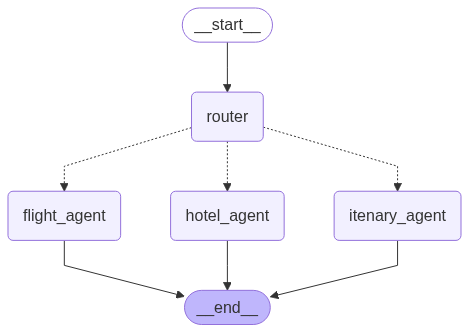

In [ ]:
from IPython.display import Image, display

# Generate and display the graph
graph_image = travel_planner.get_graph().draw_mermaid_png()
display(Image(graph_image))

## Step 9 - Test Your Mullti-Agent System

In [ ]:
from langchain_core.messages import HumanMessage

def test_system(query):
    """Test our multi-agent system"""
    print(f"🧑 User: {query}")

    # Create initial state
    initial_state = {
        "messages": [HumanMessage(content=query)],
        "next_agent": ""
    }

    # Run the system (use travel_planner instead of app)
    result = travel_planner.invoke(initial_state)

    # Get the response
    response = result["messages"][-1].content
    print(f"🤖 Assistant: {response}")
    print("-" * 50)

In [ ]:
# Test with different queries
test_system("I need to book a flight to Paris")
test_system("Find me a good hotel in New Delhi on 15 July 2025 for 1 night for 1 adult")
#test_system("What's the weather like in Paris?")

🧑 User: I need to book a flight to Paris
🧭 Router analyzing: 'I need to book a flight to Paris...'
🎯 Router decision: FLIGHT → flight_agent
🤖 Assistant: Okay, I can help you with that. Where are you flying from? And what dates are you looking at?
--------------------------------------------------
🧑 User: Find me a good hotel in New Delhi on 15 July 2025 for 1 night for 1 adult
🧭 Router analyzing: 'Find me a good hotel in New Delhi on 15 July 2025 ...'
🎯 Router decision: HOTEL → hotel_agent
🤖 Assistant: Here are a few hotel options in New Delhi for your trip on July 15, 2025:

1.  **Hotel Gold Regency**: A 3-star hotel with a rating of 5.0. It is approximately $37 per night. Key amenities include breakfast, free Wi-Fi, parking, and airport shuttle. It's located near Jantar Mantar and New Delhi Railway Station.

2.  **JR RESIDENCY**: This 3-star hotel has a rating of 4.9 and costs $60 per night. It offers free breakfast, free Wi-Fi, parking, and airport shuttle. It is located close to In

## Step 10 - Build an Interactive Chatbot

In [ ]:
from langchain_core.messages import HumanMessage

def multi_turn_chat():
    """Multi-turn conversation with checkpoint memory"""
    print("💬 Multi-Agent Travel Assistant (Multi-turn Mode)")
    print("=" * 50)

    # For multi-turn, you need a consistent thread/session ID
    config = {"configurable": {"thread_id": "1"}}

    while True:
        user_input = input("\n🧑 You: ")

        if user_input.lower() == 'quit':
            break

        print(f"\n📊 Processing query...")

        # For multi-turn, just add the new message
        # The graph will maintain conversation history automatically
        result = travel_planner.invoke(
            {"messages": [HumanMessage(content=user_input)]},
            config
        )

        response = result["messages"][-1].content
        print(f"\n🤖 Assistant: {response}")
        print("-" * 50)

# Test multi-turn conversation
multi_turn_chat()

💬 Multi-Agent Travel Assistant (Multi-turn Mode)

📊 Processing query...
🧭 Router analyzing: 'hi...'
🎯 Router decision: ITINERARY → itenary_agent

🤖 Assistant: Hello! I'm your personal travel itinerary planner. How can I help you plan your next trip?
--------------------------------------------------

📊 Processing query...
🧭 Router analyzing: '1 day travel plan for delhi...'
🎯 Router decision: ITINERARY → itenary_agent

🤖 Assistant: Okay, I can help you with a one-day travel plan for Delhi. To make the most of your day, I'll create an itinerary that balances historical sights, cultural experiences, and delicious food.

**One-Day Delhi Itinerary**

*   **8:00 AM:** Start your day with a visit to **Old Delhi**.

    *   Take the Delhi Metro to **Chandni Chowk** station.
    *   Explore the bustling streets of Chandni Chowk, known for its street food and traditional markets.
    *   **Breakfast:** Have a traditional Delhi breakfast at **Karim's** (known for its non-vegetarian dishes) or **